In [31]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 562 ms
Wall time: 587 ms


In [2]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 58.7 s
Wall time: 1min 5s


In [3]:
df.columns

Index(['uuid', 'parcel_lid', 'use_code_std_lps', 'use_code_std_desc_lps',
       'geom', 'build_id', 'prim_occ', 'new_sqmeters', 'perimeter',
       'vertex_count', 'length', 'width', 'long_side', 'short_side',
       'ls_ratio', 'pp_compactness', 'min_bounding_circle_area',
       'reock_compactness', 'sch_compactness', 'lon', 'lat',
       'points_in_polygon_buffers', 'ls_ratios_mean', 'ls_ratios_std',
       'ls_ratios_min', 'ls_ratios_max', 'area_mean', 'area_std', 'area_min',
       'area_max', 'mh_flag'],
      dtype='object')

In [4]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

CPU times: total: 625 ms
Wall time: 601 ms


In [5]:
df.head(2)

,new_sqmeters,perimeter,vertex_count,length,width,long_side,short_side,ls_ratio,pp_compactness,min_bounding_circle_area,...,points_in_polygon_buffers,ls_ratios_mean,ls_ratios_std,ls_ratios_min,ls_ratios_max,area_mean,area_std,area_min,area_max,mh_flag
uuid,,,,,,,,,,,,,,,,,,,,,
{41d5cadc-9dfb-4286-8c95-679ddc040416},505.712776,109.244544,6,38.737520,25.867066,38.73752,25.867066,1.497561,0.532493,1318.869211,...,14,1.184490,0.180276,1.011278,1.497561,195.826218,135.620522,42.908956,505.712776,0
{41d5cfec-707c-4d24-867e-a158aa450156},98.069987,57.020126,6,19.236482,19.350590,19.35059,19.236482,1.005932,0.379044,416.036078,...,5,1.587689,0.606463,1.005932,2.334468,165.185151,83.271834,98.069987,294.207192,0


In [6]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df.drop(columns=['mh_flag'], axis=1)
y = df['mh_flag']

CPU times: total: 188 ms
Wall time: 190 ms


In [7]:
%%time
"Splitting into training and testing datasets"

X_train_v1, X_test, y_train_v1, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 3.42 s
Wall time: 3.43 s


In [8]:
%%time
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train_v1, y_train_v1)

CPU times: total: 1.53 s
Wall time: 1.5 s


In [14]:
%%time
"Checking for class imbalance"

# df.mh_flag.value_counts(normalize=True)
print(y_train_v1.value_counts())
print(X_test.value_counts())

mh_flag
0    1551694
1     112610
Name: count, dtype: int64
new_sqmeters   perimeter    vertex_count  length      width       long_side   short_side  ls_ratio  pp_compactness  min_bounding_circle_area  reock_compactness  sch_compactness  lon            lat             points_in_polygon_buffers  ls_ratios_mean  ls_ratios_std  ls_ratios_min  ls_ratios_max  area_mean     area_std       area_min    area_max     
18.387368      19.758140    4             6.152450    7.516558    7.516558    6.152450    1.221718  0.591885        47.847371                 0.384292           0.769341         890267.781036  -252877.212460  1                          1.221718        0.000000       1.221718       1.221718       18.387368     0.000000       18.387368   18.387368        1
232.936747     66.629965    4             13.108242   24.471172   24.471172   13.108242   1.866854  0.659339        503.070292                0.463030           0.811997         818077.371084  -285171.745057  119                   

In [15]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 125 ms
Wall time: 129 ms


In [16]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 4.14 ms


['my_standard_scaler.pkl']

In [17]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 172 ms
Wall time: 170 ms


In [19]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [21]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier()

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
param_grid = {'max_depth': [2, 5, 10, 20],
              'max_leaves': [2, 5, 10, 20, 30, 40, 50]}

In [33]:
grid = GridSearchCV(estimator=base_xg, param_grid=param_grid, scoring='f1')

In [34]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_leaves': [2, 5, 10, 20, 30, 40, 50]},
             scoring='f1')

In [35]:
print(grid.best_params_)

{'max_depth': 10, 'max_leaves': 50}


In [37]:
%%time
"Fitting random forest"
final_xg = xgb.XGBClassifier(max_depth=10, max_leaves=50)

final_xg.fit(X_train, y_train)

CPU times: total: 10.4 s
Wall time: 1.35 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=50,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
%%time
"Using the trained random forest to predict on the testing set"

final_xg_predict = final_xg.predict(X_test)

CPU times: total: 3.47 s
Wall time: 528 ms


In [39]:
%%time
"Checking validity of the random forest's output"

final_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 1, 0, ..., 1, 0, 0])

In [40]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, final_xg_predict)
print(xg_cmatrix)

[[553307 210961]
 [  7460  48004]]
CPU times: total: 156 ms
Wall time: 165 ms


In [41]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, final_xg_predict))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84    764268
           1       0.19      0.87      0.31     55464

    accuracy                           0.73    819732
   macro avg       0.59      0.79      0.57    819732
weighted avg       0.93      0.73      0.80    819732

CPU times: total: 1.53 s
Wall time: 1.54 s


CPU times: total: 78.1 ms
Wall time: 82.9 ms


<Axes: >

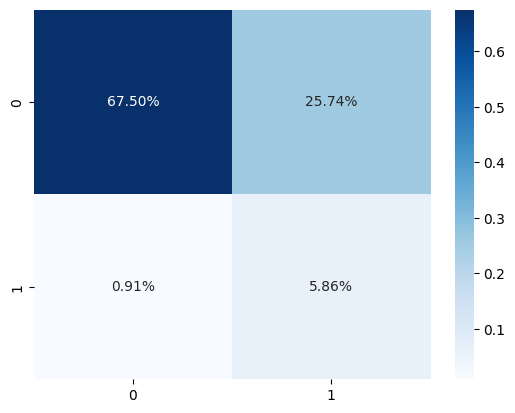

In [42]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

sns.heatmap(xg_cmatrix/np.sum(xg_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')